**Introduction** 

Imagine a five-play possession that ended in a goal in which the credited players were the scoring player and up to two assisting players. However, how can we credit the other players who helped develop the possession? Which offensive action was the most impactful and significant to put the team in a position to score? We borrowed a soccer analytics concept called Expected Threat (xT) developed by Karun Singh to answer these questions. With xT, we grade offensive production based on the field location at the end vs. the start of the play. In addition to adapting xT to hockey, we expanded it by adding time-remaining-in-period and turnover probability. We name the new metric: Net Expected Threat (nxT).

The original xT model recognizes that at any point, a player possessing the puck has two options: to shoot (attempt to score) or to move the puck (zone-entry or pass). If a player chooses to shoot, the score-probability will depend on field location. If a player decides to move, there are multiple probable destinations, each with a different probability of success, depending on field location. xT generated  (xTg) is the difference between xT at the start and xT at the end of the action. xTg considers all possibilities and assesses how much a player helped the team place the puck in a position to score, regardless of the actual possession's outcome. One of the many benefits of this metric is the ability to divide credit. Take our five-play scoring-possession example. In that scenario, we can divide the xTg of each move action over the possession's total xTg. The result would be credit percentages to calculate which action or player had the highest impact.  
In this submission, we explain how nxT expands xT to analyze a broader range of outcomes. Then, we describe the methodology behind nxT. Finally, we utilize nxT generated (nxTg) to grade offensive players for scouting purposes.

**Problem statement**

Hockey analysts utilize metrics such as expected passes and goals to grade offensive hockey players. However, there is still a need to quantify each move action's impact to generate a scoring threat. Expected Threat Generated xTg (the difference between xT at the start and xT at the end of the action) is a partial solution, but some limitations exist. xT only considers field position when assessing the potential threat. Also, xT does not account for the probability of losing the puck; therefore, we cannot measure the impact of unsuccessful move actions (turnovers). As a result, xT can only quantify the effect of completed passes and successful zone-entries. 

There is a glaring opportunity to generate a metric that quantifies the impact of successful and unsuccessful move actions, regardless of the outcome of the possession, and incorporates additional variables. By successfully addressing these limitations, we would quantify the impact of every offensive move action. The new metric would facilitate the scouting process by quickly analyzing large amounts of data and identifying threat-generating players. 

**Solution**

We expanded xT by adding time-remaining-in-period to the score probability estimation. We then generated score-probability matrices to implement them into our xT model. Accounting for the probability of a turnover required a dynamic programming approach, similar to Singh's process. We split the field into 128 cells: 8 width cells and 16 length cells. Then, we estimated the probability of losing the puck at each cell, each probable turnover cell location, and the hypothetical opposing xT for each turnover cell location. By multiplying each cell's probability of turnover by their corresponding xT, we sum the entries to obtain Opposing Expected Threat (oxT).  oxT is the Expected Threat that the defensive team has at a given moment. 

We add the probability of turnover to xT by obtaining the difference between the possession team's Expected Threat (xT) and the opposing team's Expected Threat (oxT). The resulting metric is called Net Expected Threat (nxT), which is our proposed solution. 

$nxT = oxT - xT$

To quantify each move action's impact, we calculate the difference in nxT before and after each play. 

$nxTg = nxT$ after the play - $nxT$ before the play

By using oxT, we can measure the impact of a turnover by doing: 

$nxTg$ in turnover = ($oxT$ at the end of the play) – $nxT$

nxT is the Expected Threat that team e had before the turnover (as the possession team). oxT is the Expected Threat that team e has after the turnover (now as the defensive team). As equation c) shows, oxT is needed to estimate the effect of turnovers. The previous methodology of xT was limited to equation b) and ignored unsuccessful actions: when the possession team loses the puck.

**Methodology**

Thanks to the SoccerAction team for their open-source module, we leveraged their xT model as a blueprint and codebase to build our own hockey xT module. Special thanks to Karun Singh for developing the methodology behind xT.

Terminology:

•	Grid: 16-length x 8-width grid with 128 different cells: we split the rink into zones or cells to facilitates the analysis and avoids overfitting

•	Move action: a pass attempt or a zone-entry attempt

•	Move probability $m_{xyt}$: the probability of opting to move in a cell $(x,y)$ during time 𝑡. Estimated by the rate of move actions over the total number of actions per cell

•	Shoot probability $s_{xyt}$: the probability of a player attempting to shooting in a cell $(x,y)$ during time 𝑡. Estimated by the rate of shots over the total number of actions per cell

•	Goal probability $g_{xyt}$: the scoring probability in a cell $(x,y)$ during time 𝑡 when a player shoots. Estimated using a score-probability model including variables: 𝑥, 𝑦, Euclidean distance, and time-remaining-in-period ($t$)

•	Move transition matrix $T_{xy}$: the probability of a player moving from the current cell $(x,y)$ to another cell $(z,w)$. Each cell contains 128 different probabilities. For sample size reasons, this computation does not take time-remaining-in-period into consideration

•	Turnover transition matrix $L_{xy}$: the probability of a turning over the puck from the current cell $(x,y)$ to any other cell $(z,w)$. Each cell contains 128 different probabilities. For sample size reasons, this computation does not take time-remaining-in-period into consideration

•	Time-remaining-in-period ($t$): We use four different time-remaining bins $t_{1}$ = More than 15 minutes, $t_{2}$ = between 10 and 15 minutes, $t_{3}$ = between 5 and 10 minutes, and $t_{4}$ = less than 5 minutes.

**Expected Threat**

First, we generate the $xT$ by following a similar methodology to Singh but adding the extra feature $t$. 

Following Singh's methodology, let $xT_{xy}$ be the expected payoff of a cell $(x,y)$. For simplicity, we will assume all only one bin of $t$. the incorporation of t will be explained later. 
1.	If a player shoots, then $xT_{xy} = g_{xy}$. If we are uncertain of the player's decision, we multiply shoot probability s times $xT_{xy}$ when shooting. 

2.	If the player moves, there are 128 possible destinations, each one with a different expected payoff. Suppose a player moves from $(x,y)$ to $(z,w)$. In that case, the expected payoff of $(z,w)$ is $xT_{zw}$ multiplied times the probability of moving to $(z,w)$ from $(x,y)$. Since there are 128 possible locations, we estimate $xT_{zw}$ of all $(z,w)$ locations and sum the results. The result is $xT_{xy}$ when moving. We use the transition matrix $T_{xy}$ to estimate this. If we are uncertain of the player's decision, we multiply the probability of moving m  times $xT_{xy}$ when moving. 

3.	If we add $xT_{xy}$ when shooting and $xT_{xy}$ when moving, both under uncertainty of decision, we get the total $xT$, which we simply call $xT_{xy}$


change 12 to 8*

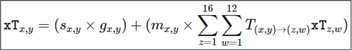

**Solving for xT**

For simplicity, we will assume all only one bin of t. the incorporation of t will be explained later. 

To solve the equation n, Singh proposes assigning $xT = 0$ to all cells $(x,y)$ and then evaluate the formula iteratively until convergence. At each iteration, we assess the new xT for each zone using $xT$ values from the previous iteration. Each new iteration utilizes $xT$ values of the prior iteration as $xT_{zw}$. Therefore, the more iterations, the higher the possible number of actions before the shoot-attempt we are considering. In other words, with 10 iterations, we are looking at up to 10 moves ahead of each scenario! When we end our simulation for every bin, we obtain an 8x16 matrix with 128 values, each one representing the $xT$ of a given cell. This matrix is simply called $xT$. 

Figure f represents the dynamic between transition matrices for each cell and $xT$.

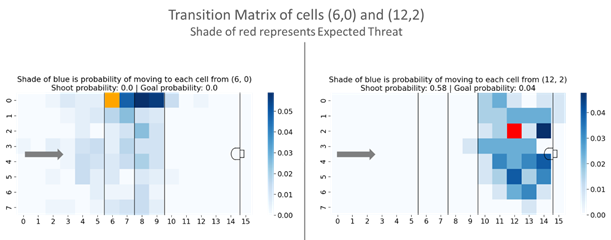

**Accounting for the time remaining in the period**

To incorporate $t$, we created four different score probability matrices utilizing a random-forest algorithm. The following figure explains the difference in score probability by every bin of $t$.


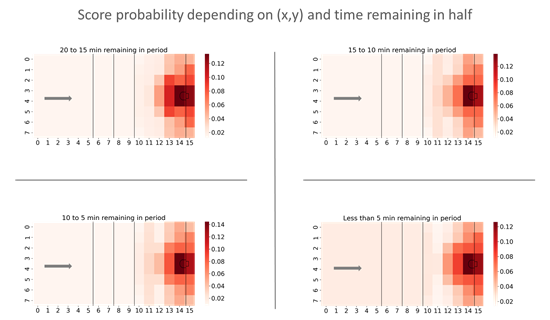

Since we added an extra feature to the model t, we need to solve the equation four times to utilize the corresponding score-probability matrix. We split the training set into four subsamples based on time-remaining-in-period. Finally, we train to model correspondingly, obtaining thus $m_{xyt}$, $s_{xyt}$, and $g_{xyt}$. The two exceptions are move transition matrix $T_{xy}$ and turnover transition matrix L$_{xy}$. 

add $t$ where needed*

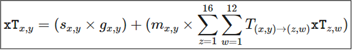

**Opposing and Net Expected Threat**

We developed an Opposing Expected Threat $(oxT)$ and a Net Expected threat $(nxT)$ to solve our problem statement. To generate $oxT$, we followed a similar approach to the move transition matrix $(T_{xy})$. Still, we utilized failed move-actions (turnovers) instead of successful ones. We call it the turnover transition matrix $(L_{xy})$. We use $L_{xy}$ to estimate the probability of turning over the puck at every possible cell in the rink. 


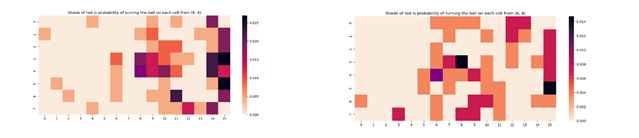

The next step is to use the xT grid we generated in our original $xT$ model. By calculating the Element-wise product of  $L_{xy}$ and $xT_{t}$, and summing over all the entries, we obtain $oxT_{xyt}$. $oxT_{xyt}$ is the opposing expected threat in the cell $(x,y)$ during time $t$. Think of $oxT_{xyt}$ as the defensive team's expected threat when the offensive team is in the cell $(x,y)$ during time $t$. The sum of all entries of $L_{xy}$ is the probability of turnover in point $(x,y)$.

$oxT_{xyt} = \sum(L_{xy} \circ xT_{t})$

To obtain the $nxT$ of cell $(x,y)$ during time $t$, we calculate the difference between $xT_{xyt}$ and $oxT_{xyt}$

$nxT_{xyt} = xT_{xyt} - oxT_{xyt}$

Since we have four different matrices of xT depending on the bin of t, we need to run the process four times. 
Figure z presents the $xT$, $oxT$, and $nxT$ grid, respectively. For simplicity, this visualization does not take t into consideration.

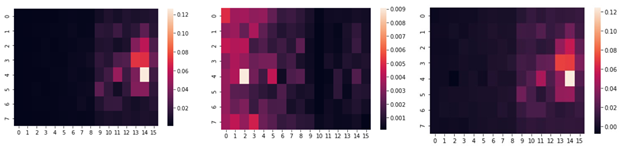

**Results**

To utilize nxT to grade players, we obtain the top and bottom 10 players and teams in nxTg in our sample. Also, we visualize an example of how to use xT for the proper division of credit during a given play.

**Action points**

Using this metric, we were able to grade thousands of players in the scouting league in offensive production regardless of their position. Every move action generates xT irrespective of how close the play happened to the opposing net and whether the possession ended in a goal or not. nxT can quantify the effect of both successful and failed move attempts; therefore, players making mistakes are penalized accordingly. 

We invite teams and scouting departments to implement a version of this metric to boost their scouting efforts and provide an extra layer of information to their evaluation and decision-making process. We create an open-source python module available here to facilitate our metric's implementation. 

We are presenting examples of visualizations to analyze players and teams using nxTg. 